# load papers into memory and store a list of JSON objects

In [15]:
import os
import json
import numpy as np
import logging
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.corpus import stopwords

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Download required NLTK resources
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

def load_papers(directory_path, limit=None):
    """
    Load papers from JSON files in a directory structure
    
    Args:
        directory_path: Path to the directory containing JSON files
        limit: Maximum number of papers to load (for testing)
        
    Returns:
        List of paper dictionaries
    """
    papers = []
    logging.info(f"Loading papers from {directory_path}")
    
    counter = 0
    for root, _, files in os.walk(directory_path):
        for file in files:
            if limit and counter >= limit:
                break
                
            if file.endswith('.json'):
                counter += 1
                print(f"\rProcessing: {counter}", end='', flush=True)
                file_path = os.path.join(root, file)
                try:
                    with open(file_path, 'r', encoding='utf-8') as f:
                        paper_data = json.load(f)
                    
                    # Add file path information for reference
                    paper_data['file_path'] = file_path
                    papers.append(paper_data)
                                            
                except Exception as e:  
                    logging.error(f"Error loading {file_path}: {e}")
        
        if limit and counter >= limit:
            break
            
    logging.info(f"Finished loading {counter} papers")
    return papers

def save_papers_to_json(papers, output_file='processed_papers.json'):
    """
    Save the entire dataset of papers to a single JSON file
    
    Args:
        papers: List of paper dictionaries
        output_file: Path to the output JSON file
    """
    output_dir = os.path.dirname(output_file)
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    logging.info(f"Saving {len(papers)} papers to {output_file}")
    try:
        with open(output_file, 'w', encoding='utf-8') as f:
            json.dump(papers, f, ensure_ascii=False, indent=2)
        logging.info(f"Successfully saved papers to {output_file}")
    except Exception as e:
        logging.error(f"Error saving papers to {output_file}: {e}")

# Load a sample of papers for demonstration
papers = load_papers('irCOREdata', limit=None)

# Save the entire dataset to a single JSON file
# save_papers_to_json(papers, output_file='processed_data/all_papers.json')

Processing: 21840

In [16]:
print(complete_papers)

[{'doi': '10.1007/s00221-006-0582-8', 'coreId': '65664', 'oai': 'oai:dro.dur.ac.uk.OAI2:5143', 'identifiers': ['oai:dro.dur.ac.uk.OAI2:5143', '10.1007/s00221-006-0582-8'], 'title': 'TMS can reveal contrasting functions of the dorsal and ventral visual processing streams.', 'authors': ['Ellison,  A.', 'Cowey,  A.'], 'enrichments': {'references': [], 'documentType': {'type': 1}}, 'contributors': [], 'datePublished': '2006-11-01', 'abstract': 'In order to investigate the functional specificity of the dorsal and ventral visual processing steams we used transcranial magnetic stimulation (TMS) to briefly disrupt one or the other while subjects performed three tasks, involving discrimination of colour or shape or relative position. TMS was delivered over right posterior parietal cortex (PPC) or right lateral occipital (LO) cortex, regions known to have visuo-spatial and object processing properties respectively. LO but not PPC stimulation had a significant effect on reaction time when subject

# load evaluation models


In [1]:
import logging
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import os
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("C-KAI/sbert-academic-group44")

# models = [
#     # "mistralai/Mistral-7B-Instruct-v0.3",
#     # "google/gemma-7b-it",
#     # "meta-llama/Meta-Llama-3-8B-Instruct",  # Correct capitalization based on HF page
#     'meta-llama/Llama-3.1-8B-Instruct'
# # ]
# import transformers
# import torch

# model_name = "meta-llama/Meta-Llama-3-8B-Instruct"


# # Now save the model after loading it
# pipeline.model.save_pretrained("./saved_llama_model")
# pipeline.tokenizer.save_pretrained("./saved_llama_model")

# # Now save the model after loading it
# try:
#     logging.info(f"Processing model: {model_name}")
    
#     # Extract folder name from model name
#     folder_name = model_name.split("/")[-1]
    
#     # Define the save directory
#     save_dir = os.path.join("evaluation", "models", folder_name)
#     os.makedirs(save_dir, exist_ok=True)
    
#     logging.info(f"Saving model to: {save_dir}")
    
#     # Get the model and tokenizer from the pipeline
#     model = pipeline.model
#     tokenizer = pipeline.tokenizer
    
#     # Print absolute path for debugging
#     abs_path = os.path.abspath(save_dir)
#     logging.info(f"Saving model to: {abs_path}")
    
#     # Save the model and tokenizer
#     # Using max_shard_size to handle large models
#     model.save_pretrained(save_dir, max_shard_size="5GB")
#     tokenizer.save_pretrained(save_dir)
    
#     logging.info(f"Successfully saved {model_name} to {save_dir}")
    
# except Exception as e:
#     logging.error(f"Error saving {model_name}: {str(e)}")
#     # Print full traceback for better debugging
#     import traceback
#     traceback.print_exc()

/home/kasey/miniconda3/envs/search_engine/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
You are trying to use a model that was created with Sentence Transformers version 4.0.2, but you're currently using version 4.0.1. This might cause unexpected behavior or errors. In that case, try to update to the latest version.


# data exploration 

In [18]:
def analyze_missing_fields(papers):
    """
    Analyzes how fields are missing in the papers dataset.
    Distinguishes between missing keys, None values, empty strings, and empty lists.
    """
    total_papers = len(papers)
    
    # Initialize counters for different types of missing data
    field_stats = {
        'title': {'missing_key': 0, 'is_none': 0, 'empty_string': 0, 'empty_list': 0},
        'abstract': {'missing_key': 0, 'is_none': 0, 'empty_string': 0, 'empty_list': 0},
        'fullText': {'missing_key': 0, 'is_none': 0, 'empty_string': 0, 'empty_list': 0},
        'topics': {'missing_key': 0, 'is_none': 0, 'empty_string': 0, 'empty_list': 0}
    }
    
    # Check each paper and count different ways fields can be missing
    for paper in papers:
        for field in field_stats.keys():
            # Check if the key is missing
            if field not in paper:
                field_stats[field]['missing_key'] += 1
            # Key exists but value is None
            elif paper[field] is None:
                field_stats[field]['is_none'] += 1
            # Key exists but value is empty string
            elif isinstance(paper[field], str) and paper[field].strip() == '':
                field_stats[field]['empty_string'] += 1
            # Key exists but value is empty list
            elif isinstance(paper[field], list) and len(paper[field]) == 0:
                field_stats[field]['empty_list'] += 1
    
    # Print the results
    print(f"Analysis of missing fields across {total_papers} papers:\n")
    
    for field in field_stats:
        stats = field_stats[field]
        total_missing = stats['missing_key'] + stats['is_none'] + stats['empty_string'] + stats['empty_list']
        
        print(f"=== {field.upper()} FIELD ===")
        print(f"Total effectively missing: {total_missing} ({total_missing/total_papers:.1%})")
        print(f"  - Key not in JSON: {stats['missing_key']} ({stats['missing_key']/total_papers:.1%})")
        print(f"  - Value is None: {stats['is_none']} ({stats['is_none']/total_papers:.1%})")
        print(f"  - Empty string: {stats['empty_string']} ({stats['empty_string']/total_papers:.1%})")
        print(f"  - Empty list: {stats['empty_list']} ({stats['empty_list']/total_papers:.1%})\n")
    
    # Also calculate how many papers are missing specific combinations of fields
    missing_abstract_and_fulltext = 0
    missing_title = 0
    missing_all_three = 0
    
    for paper in papers:
        # Check title
        has_title = ('title' in paper and paper['title'] is not None and 
                    isinstance(paper['title'], str) and paper['title'].strip() != '')
        
        # Check abstract
        has_abstract = ('abstract' in paper and paper['abstract'] is not None and 
                       isinstance(paper['abstract'], str) and paper['abstract'].strip() != '')
        
        # Check fullText
        has_fulltext = ('fullText' in paper and paper['fullText'] is not None and 
                       isinstance(paper['fullText'], str) and paper['fullText'].strip() != '')
        
        # Count papers missing combinations
        if not has_title:
            missing_title += 1
            
        if not has_abstract and not has_fulltext:
            missing_abstract_and_fulltext += 1
            
        if not has_title and not has_abstract and not has_fulltext:
            missing_all_three += 1
    
    print(f"=== FIELD COMBINATIONS ===")
    print(f"Papers missing title: {missing_title} ({missing_title/total_papers:.1%})")
    print(f"Papers missing both abstract AND fullText: {missing_abstract_and_fulltext} ({missing_abstract_and_fulltext/total_papers:.1%})")
    print(f"Papers missing all three main fields: {missing_all_three} ({missing_all_three/total_papers:.1%})")
    
    return field_stats

# Run the analysis
field_stats = analyze_missing_fields(papers)

# Find and store 100 documents that contain all four fields (title, abstract, fullText, topics)
def find_complete_documents(papers, num_docs=10):
    """
    Find documents that have all four fields: title, abstract, fullText, and topics.
    
    Args:
        papers: List of paper dictionaries
        num_docs: Number of complete documents to find (default: 100)
        
    Returns:
        List of complete paper dictionaries
    """
    complete_docs = []
    
    for paper in papers:
        # Check if all fields exist and are not empty
        has_title = ('title' in paper and paper['title'] is not None and 
                    isinstance(paper['title'], str) and paper['title'].strip() != '')
        
        has_abstract = ('abstract' in paper and paper['abstract'] is not None and 
                       isinstance(paper['abstract'], str) and paper['abstract'].strip() != '')
        
        has_fulltext = ('fullText' in paper and paper['fullText'] is not None and 
                       isinstance(paper['fullText'], str) and paper['fullText'].strip() != '')
        
        has_topics = ('topics' in paper and paper['topics'] is not None and 
                     isinstance(paper['topics'], list) and len(paper['topics']) > 0)
        
        # If all fields are present, add to our collection
        if has_title and has_abstract and has_fulltext and has_topics:
            # Create a copy of the paper and truncate the fullText to first 10 lines
            paper_copy = paper.copy()
            if 'fullText' in paper_copy and paper_copy['fullText']:
                lines = paper_copy['fullText'].split('\n')
                paper_copy['fullText'] = '\n'.join(lines[:10])
            
            complete_docs.append(paper_copy)
            
            # Stop once we have enough documents
            if len(complete_docs) >= num_docs:
                break
    
    print(f"Found {len(complete_docs)} complete documents with all four fields")
    print(f"Note: fullText field has been truncated to first 10 lines")
    
    # Save these documents for later use
    import pickle
    with open('complete_documents.pkl', 'wb') as f:
        pickle.dump(complete_docs, f)
    print("Saved complete documents to 'complete_documents.pkl'")
    
    return complete_docs

# Find 100 complete documents
complete_docs = find_complete_documents(papers)

Analysis of missing fields across 21840 papers:

=== TITLE FIELD ===
Total effectively missing: 0 (0.0%)
  - Key not in JSON: 0 (0.0%)
  - Value is None: 0 (0.0%)
  - Empty string: 0 (0.0%)
  - Empty list: 0 (0.0%)

=== ABSTRACT FIELD ===
Total effectively missing: 5947 (27.2%)
  - Key not in JSON: 0 (0.0%)
  - Value is None: 5947 (27.2%)
  - Empty string: 0 (0.0%)
  - Empty list: 0 (0.0%)

=== FULLTEXT FIELD ===
Total effectively missing: 13243 (60.6%)
  - Key not in JSON: 0 (0.0%)
  - Value is None: 11125 (50.9%)
  - Empty string: 2118 (9.7%)
  - Empty list: 0 (0.0%)

=== TOPICS FIELD ===
Total effectively missing: 5422 (24.8%)
  - Key not in JSON: 0 (0.0%)
  - Value is None: 0 (0.0%)
  - Empty string: 0 (0.0%)
  - Empty list: 5422 (24.8%)

=== FIELD COMBINATIONS ===
Papers missing title: 0 (0.0%)
Papers missing both abstract AND fullText: 4890 (22.4%)
Papers missing all three main fields: 0 (0.0%)
Found 10 complete documents with all four fields
Note: fullText field has been truncat

In [19]:
print(complete_docs)

[{'doi': '10.1007/s00221-006-0582-8', 'coreId': '65664', 'oai': 'oai:dro.dur.ac.uk.OAI2:5143', 'identifiers': ['oai:dro.dur.ac.uk.OAI2:5143', '10.1007/s00221-006-0582-8'], 'title': 'TMS can reveal contrasting functions of the dorsal and ventral visual processing streams.', 'authors': ['Ellison,  A.', 'Cowey,  A.'], 'enrichments': {'references': [], 'documentType': {'type': 1}}, 'contributors': [], 'datePublished': '2006-11-01', 'abstract': 'In order to investigate the functional specificity of the dorsal and ventral visual processing steams we used transcranial magnetic stimulation (TMS) to briefly disrupt one or the other while subjects performed three tasks, involving discrimination of colour or shape or relative position. TMS was delivered over right posterior parietal cortex (PPC) or right lateral occipital (LO) cortex, regions known to have visuo-spatial and object processing properties respectively. LO but not PPC stimulation had a significant effect on reaction time when subject

# extarct fields

In [20]:
def extract_fields(papers):
    """
    Extract title, abstract and body text from papers
    
    Args:
        papers: List of paper dictionaries
        
    Returns:
        Dictionary of extracted fields and paper IDs
    """
    titles = []
    abstracts = []
    bodies = []
    paper_ids = []
    topics = []
    counter = 0
    for paper in papers:
        counter += 1
        print(f"\rProcessing: {counter}", end='', flush=True)
        # Extract ID
        paper_id = paper.get('coreId')
        paper_ids.append(paper_id)  
        
        # Extract title - handle missing cases
        title = paper.get('title')
        titles.append(title if isinstance(title, str) and title.strip() != '' else '')
        
        # Extract abstract - handle None values
        abstract = paper.get('abstract')
        abstracts.append(abstract if isinstance(abstract, str) and abstract.strip() != '' else '')
        
        # Extract fullText - handle None values and empty strings
        fulltext = paper.get('fullText')
        bodies.append(fulltext if isinstance(fulltext, str) and fulltext.strip() != '' else '')
        
        # Extract topics - handle empty lists
        topic_data = paper.get('topics')
        if isinstance(topic_data, list) and len(topic_data) > 0:
            topics.append(topic_data)
        else:
            topics.append('')
    
    return {
        'paper_ids': paper_ids,
        'titles': titles,
        'abstracts': abstracts,
        'bodies': bodies,
        'topics': topics
    }

# Extract fields from loaded papers
extracted_fields_dict = extract_fields(papers)







Processing: 21840Found 100 complete documents with all fields present


paper_id                                              title  \
0    65664  TMS can reveal contrasting functions of the do...   
1    66516  Galaxy number counts - V. Ultradeep counts : t...   
2    65589  Untangling differentiation in arc lavas : cons...   
3    63414  Geoscience after IT: Part H. Familiarization w...   
4    62534  Estimate of annual NH3 dry deposition to a fum...   

                                            abstract  \
0  In order to investigate the functional specifi...   
1  We present u, b, r and i galaxy number counts ...   
2  Volcanic rocks from Salak Volcano in West Java...   
3  The geoscience record stores information for l...   
4  Estimates of the dry deposition of ammonia (NH...   

                                                body  \
0  Durham Research Online\nDeposited in DRO:\n17 ...   
1  Durham Research Online\nDeposited in DRO:\n29 ...   
2  Durham Research Online\nDeposited in DRO:\n01 ...   
3  <<<Back to Table of Contents       \nOn to Par...   
4   \n \n \nArticle (refereed) \n \n \n \nCape, J...   

                                              topics  has_title  has_abstract  \
0  [Ventral stream, Dorsal stream, Visual discrim...       True          True   
1  [Galaxies, Evolution, Photometry, Cosmology, O...       True          True   
2  [Crustal contamination, Fractional crystallisa...       True          True   
3  [Computer Science, Data and Information, Earth...       True          True   
4  [Agriculture and Soil Science, Ecology and Env...       True          True   

   has_body  has_topics  
0      True        True  
1      True        True  
2      True        True  
3      True        True  
4      True        True

#  analaysis of topics for test set creation 

Found 13176 unique topics

Sample of topics:
1. Earcons
2. Triangulation
3. recruitment
4. Prefrontal
5. Handover management,
6. Return reversal
7. Automobile
8. Journal history
9. MECHANISMS
10. ; Human remains
11. Corneal Topography
12. optical fibre Bragg gratings phase-shifted Bragg gratings Rouard's model scanning beam technique optical-fibers laser filter masks
13. Urotensin II
14. Large rivers.
15. Social capital
16. LC Special aspects of education
17. Sol–gel methods
18. Senior management
19. Meshless
20. Microbiological Techniques
Total topics analyzed: 35472
Topics with non-alphabetic characters: 12165 (34.3%)
Topics with numbers: 3949 (11.1%)
Topics with special characters: 9737 (27.4%)
Topics with URLs: 0 (0.0%)
Topics in all caps: 508 (1.4%)
Single-word topics: 7930 (22.4%)
Likely invalid topics: 2076 (5.9%)

Examples of likely invalid topics:
1. 'HD28 Management. Industrial Management' - Issues: has_non_alpha, has_numbers, has_special_chars
2. 'Z665 Library Science. Infor

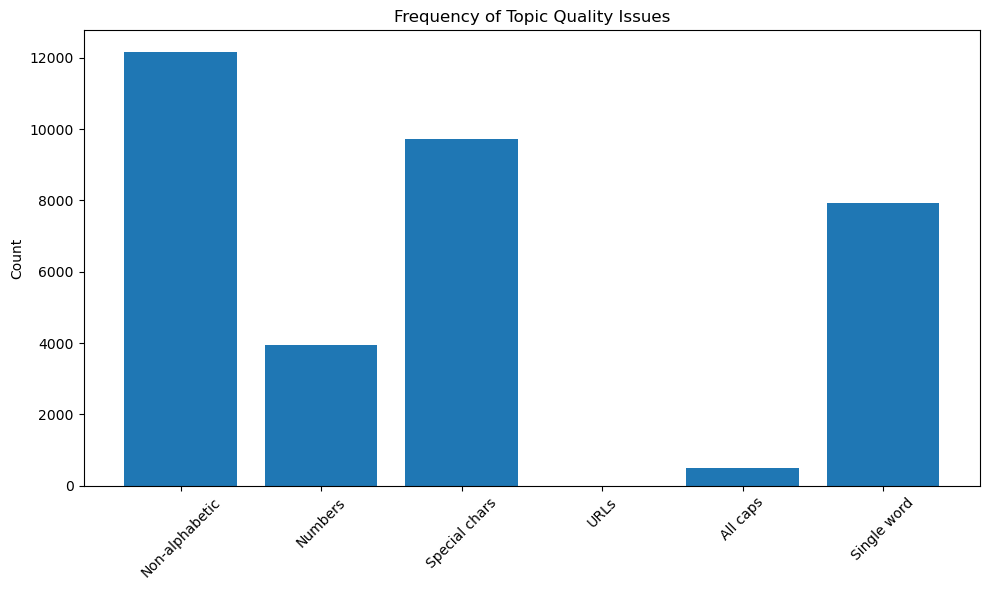

In [27]:
# Analyze topics to create a set of all unique topics
all_topics = set()

# Iterate through the topics list in the extracted fields dictionary
for topic_list in extracted_fields_dict['topics']:
    # Check if the topic_list is a list (not an empty string)
    if isinstance(topic_list, list):
        # Add each topic to the set
        for topic in topic_list:
            all_topics.add(str(topic))  # Convert to string to ensure consistency

# Print the number of unique topics found
print(f"Found {len(all_topics)} unique topics")

# Display a sample of topics (first 20 if available)
sample_size = min(20, len(all_topics))
sample_topics = list(all_topics)[:sample_size]
print(f"\nSample of topics:")
for i, topic in enumerate(sample_topics, 1):
    print(f"{i}. {topic}")

# Analyze topics for non-alphabetic characters and other indicators of invalid topics
import re
import pandas as pd
import matplotlib.pyplot as plt

def analyze_topic_quality(topics_list):
    """
    Analyze topics for potential issues that would indicate they're not valid scientific topics.
    
    Args:
        topics_list: List of topic strings to analyze
        
    Returns:
        DataFrame with analysis results
    """
    # Initialize counters for different issues
    analysis_results = {
        'topic': [],
        'length': [],
        'has_non_alpha': [],
        'has_numbers': [],
        'has_special_chars': [],
        'has_urls': [],
        'all_caps': [],
        'single_word': [],
        'likely_invalid': []
    }
    
    # Compile regex patterns
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    special_char_pattern = re.compile(r'[^\w\s]')
    number_pattern = re.compile(r'\d')
    
    # Analyze each topic
    for topic in topics_list:
        if not topic or topic == '':
            continue
            
        # Clean up the topic string
        topic_str = str(topic).strip()
        
        # Calculate metrics
        length = len(topic_str)
        has_non_alpha = bool(re.search(r'[^a-zA-Z\s]', topic_str))
        has_numbers = bool(number_pattern.search(topic_str))
        has_special_chars = bool(special_char_pattern.search(topic_str))
        has_urls = bool(url_pattern.search(topic_str))
        all_caps = topic_str.isupper() and length > 3
        single_word = len(topic_str.split()) == 1
        
        # Determine if likely invalid
        likely_invalid = (
            has_urls or 
            (has_special_chars and has_numbers) or
            (length < 3) or
            (topic_str in ['null', 'undefined', 'none', 'nan'])
        )
        
        # Add to results
        analysis_results['topic'].append(topic_str)
        analysis_results['length'].append(length)
        analysis_results['has_non_alpha'].append(has_non_alpha)
        analysis_results['has_numbers'].append(has_numbers)
        analysis_results['has_special_chars'].append(has_special_chars)
        analysis_results['has_urls'].append(has_urls)
        analysis_results['all_caps'].append(all_caps)
        analysis_results['single_word'].append(single_word)
        analysis_results['likely_invalid'].append(likely_invalid)
    
    # Convert to DataFrame
    return pd.DataFrame(analysis_results)

# Flatten the list of topics
flat_topics = []
for topic_list in extracted_fields_dict['topics']:
    if isinstance(topic_list, list):
        flat_topics.extend(topic_list)
    elif isinstance(topic_list, str) and topic_list:
        # Handle comma-separated topics in string format
        topics = [t.strip() for t in topic_list.split(',')]
        flat_topics.extend(topics)

# Analyze topic quality
topic_analysis = analyze_topic_quality(flat_topics)

# Display summary statistics
print(f"Total topics analyzed: {len(topic_analysis)}")
print(f"Topics with non-alphabetic characters: {topic_analysis['has_non_alpha'].sum()} ({topic_analysis['has_non_alpha'].mean():.1%})")
print(f"Topics with numbers: {topic_analysis['has_numbers'].sum()} ({topic_analysis['has_numbers'].mean():.1%})")
print(f"Topics with special characters: {topic_analysis['has_special_chars'].sum()} ({topic_analysis['has_special_chars'].mean():.1%})")
print(f"Topics with URLs: {topic_analysis['has_urls'].sum()} ({topic_analysis['has_urls'].mean():.1%})")
print(f"Topics in all caps: {topic_analysis['all_caps'].sum()} ({topic_analysis['all_caps'].mean():.1%})")
print(f"Single-word topics: {topic_analysis['single_word'].sum()} ({topic_analysis['single_word'].mean():.1%})")
print(f"Likely invalid topics: {topic_analysis['likely_invalid'].sum()} ({topic_analysis['likely_invalid'].mean():.1%})")

# Display examples of potentially problematic topics
print("\nExamples of likely invalid topics:")
invalid_examples = topic_analysis[topic_analysis['likely_invalid']].head(10)
for i, (_, row) in enumerate(invalid_examples.iterrows(), 1):
    print(f"{i}. '{row['topic']}' - Issues: " + 
          ", ".join([issue for issue, value in row.items() 
                    if value is True and issue not in ['topic', 'length', 'likely_invalid']]))

# Create a bar chart of issue frequencies
issue_counts = {
    'Non-alphabetic': topic_analysis['has_non_alpha'].sum(),
    'Numbers': topic_analysis['has_numbers'].sum(),
    'Special chars': topic_analysis['has_special_chars'].sum(),
    'URLs': topic_analysis['has_urls'].sum(),
    'All caps': topic_analysis['all_caps'].sum(),
    'Single word': topic_analysis['single_word'].sum()
}

plt.figure(figsize=(10, 6))
plt.bar(issue_counts.keys(), issue_counts.values())
plt.title('Frequency of Topic Quality Issues')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# keyBERT extractoin 

In [21]:
# from keybert import KeyBERT
# import torch
# from sentence_transformers import SentenceTransformer
# from tqdm import tqdm

# # Set up GPU model
# device = torch.device("cuda:0")
# model = SentenceTransformer('paraphrase-mpnet-base-v2')
# # model = SentenceTransformer('all-mpnet-base-v2') # English only, excellent performance
# model = model.to(device)  # Move to GPU
# kw_model = KeyBERT(model=model)

# # Combine relevant text fields for each document
# combined_texts = []
# for i in range(len(extracted_fields_dict['paper_ids'])):
#     # Combine title, abstract, and body with spacing between them
#     doc_text = (
#         extracted_fields_dict['titles'][i] + " " + 
#         extracted_fields_dict['abstracts'][i] + " " + 
#         extracted_fields_dict['bodies'][i]
#     ).strip()
#     combined_texts.append(doc_text)

# # Limit to processing only a few documents for this experiment
# max_docs = 100
# combined_texts = combined_texts[:max_docs]
# paper_ids = extracted_fields_dict['paper_ids'][:max_docs]

# print(f"Processing {len(combined_texts)} documents for keyword extraction...")

# # Process in batches to maximize GPU usage
# batch_size = 10  # Adjust based on document sizes and your VRAM
# all_keywords = []

# # Show progress bar
# for i in tqdm(range(0, len(combined_texts), batch_size)):
#     batch = combined_texts[i:i+batch_size]
#     # Filter out empty documents
#     batch = [doc for doc in batch if doc and len(doc) > 50]  # Minimum text length
    
#     if batch:  # Only process if batch has documents
#         batch_keywords = kw_model.extract_keywords(
#             batch,
#             keyphrase_ngram_range=(1, 1),  # Extract 1-3 word keyphrases
#             stop_words='english',
#             use_mmr=True,         # Use Maximal Marginal Relevance
#             diversity=0.7,        # Higher diversity
#             top_n=20              # Extract top 20 keywords
#         )
        
#         # Handle the structure correctly based on batch size
#         if batch_size == 1:
#             # For single docu
#             # ment batches, batch_keywords is a list of tuples
#             # Each tuple is (keyword, score)
#             filtered_keywords = [(kw, score) for kw, score in batch_keywords if score > 0.35]
#             all_keywords.append(filtered_keywords)
#         else:
#             # For multi-document batches
#             for doc_keywords in batch_keywords:
#                 if isinstance(doc_keywords, list):
#                     filtered_keywords = [(kw, score) for kw, score in doc_keywords if score > 0.35]
#                 elif isinstance(doc_keywords, tuple) and len(doc_keywords) == 2:
#                     # Handle case where doc_keywords is a single tuple
#                     kw, score = doc_keywords
#                     filtered_keywords = [(kw, score)] if score > 0.35 else []
#                 else:
#                     filtered_keywords = []
#                 all_keywords.append(filtered_keywords)
#     else:
#         # Add empty list for skipped batch
#         all_keywords.extend([[] for _ in range(min(batch_size, len(combined_texts) - i))])

# # Print the extracted keywords for each document
# print("\nKeyword extraction results:")
# for i, (doc_id, keywords) in enumerate(zip(paper_ids, all_keywords)):
#     print(f"\nDocument {i+1} (ID: {doc_id}):")
#     if keywords:
#         for keyword, score in keywords:
#             print(f"  - {keyword}: {score:.4f}")
#     else:
#         print("  No keywords extracted")

# visualize the fields and their analysis

In [22]:
def create_papers_dataframe(extracted_fields_dict):
    """
    Convert extracted paper fields into a pandas DataFrame for analysis and export
    
    Args:
        extracted_fields_dict: Dictionary containing extracted fields
        
    Returns:
        DataFrame with paper data
    """
    # Create DataFrame from the extracted fields
    df = pd.DataFrame({
        'paper_id': extracted_fields_dict['paper_ids'],
        'title': extracted_fields_dict['titles'],
        'abstract': extracted_fields_dict['abstracts'],
        'body': extracted_fields_dict['bodies']
    })
    
    # Process topics to ensure they're strings, not lists
    processed_topics = []
    for topic_list in extracted_fields_dict['topics']:
        if isinstance(topic_list, list):
            # Join list items into a single string
            processed_topics.append(', '.join(str(topic) for topic in topic_list))
        else:
            processed_topics.append(str(topic_list))
    
    # Add processed topics to DataFrame
    df['topics'] = processed_topics
    
    # Add computed columns for analysis
    df['has_title'] = df['title'].str.strip().apply(bool)
    df['has_abstract'] = df['abstract'].str.strip().apply(bool)
    df['has_body'] = df['body'].str.strip().apply(bool)
    df['has_topics'] = df['topics'].str.strip().apply(bool)
    
    
    
    print(f"Created DataFrame with {len(df)} papers")
    return df

# Create the DataFrame
papers_df = create_papers_dataframe(extracted_fields_dict)

# Export functions for the DataFrame
def export_to_csv(df, filename='papers_data.csv'):
    """Export DataFrame to CSV file"""
    df.to_csv(filename, index=False)
    print(f"Data exported to {filename}")

def export_to_excel(df, filename='papers_data.xlsx'):
    """Export DataFrame to Excel file"""
    df.to_excel(filename, index=False)
    print(f"Data exported to {filename}")


papers_df.head()
# export_to_csv(papers_df)
# export_to_excel(papers_df)

Created DataFrame with 21840 papers


paper_id                                              title  \
0    67789  Eddy current measurements of electrical conduc...   
1    65664  TMS can reveal contrasting functions of the do...   
2   209338  Local governance in Post-Soviet Armenia: leade...   
3   199339  A study of the Hartmann-Watson distribution mo...   
4   194766  Halite and stable chlorine isotopes in the Zag...   

                                            abstract  \
0  This paper presents a method, which simultaneo...   
1  In order to investigate the functional specifi...   
2                                                      
3  One approach to the computation of the price o...   
4  Zag is an H3-6 chondrite regolith breccia with...   

                                                body  \
0                                                      
1  Durham Research Online\nDeposited in DRO:\n17 ...   
2                                                      
3                                                      
4                                                      

                                              topics  has_title  has_abstract  \
0  TK Electrical engineering. Electronics Nuclear...       True          True   
1  Ventral stream, Dorsal stream, Visual discrimi...       True          True   
2  JX International law, JA Political science (Ge...       True         False   
3                                         HG Finance       True          True   
4                                                          True          True   

   has_body  has_topics  
0     False        True  
1      True        True  
2     False        True  
3     False        True  
4     False       False

# tf-idf matrix creation    

In [23]:
from scipy.sparse._matrix import spmatrix


def create_tfidf_vectors(extracted_data):
    """
    Create TF-IDF vectors for each field
    
    Args:
        extracted_data: Dictionary containing extracted fields
        
    Returns:
        Dictionary with vectorizer and field vectors
    """
    # Create and configure the vectorizer
    vectorizer = TfidfVectorizer(
        min_df=2,                  # Ignore terms that appear in fewer than 2 documents
        max_df=0.95,               # Ignore terms that appear in more than 95% of documents
        stop_words='english',      # Remove common English stop words
        lowercase=True,            # Convert all text to lowercase
        strip_accents='unicode',   # Remove accents
        token_pattern=r'\b[a-zA-Z]{3,}\b'  # Only include words with 3+ letters
    )
    
    # Process topics to ensure they're strings, not lists
    processed_topics = []
    for topic_list in extracted_data['topics']:
        if isinstance(topic_list, list):
            # Join list items into a single string
            processed_topics.append(' '.join(str(topic) for topic in topic_list))
        else:
            processed_topics.append(topic_list)
    
    # Fit on all text to create a common vocabulary or dictionary
    all_text = (
        extracted_data['titles'] + 
        extracted_data['abstracts'] + 
        extracted_data['bodies'] + 
        processed_topics
    )
    vectorizer.fit(all_text)
    
    # Transform each field separately
    title_vectors: spmatrix = vectorizer.transform(extracted_data['titles'])
    print(f'Title vectors processed: {title_vectors.shape} (documents × features)')
    abstract_vectors: spmatrix = vectorizer.transform(extracted_data['abstracts'])
    print(f'Abstract vectors processed: {abstract_vectors.shape} (documents × features)')
    body_vectors: spmatrix = vectorizer.transform(extracted_data['bodies'])
    print(f'Body vectors processed: {body_vectors.shape} (documents × features)')
    topic_vectors: spmatrix = vectorizer.transform(processed_topics)
    print(f'Topic vectors processed: {topic_vectors.shape} (documents × features)')
    
    # Log the number of features (vocabulary size)
    feature_count = len(vectorizer.get_feature_names_out())
    logging.info(f"Created TF-IDF vectors with {feature_count} features")
    
    # Print sample of vocabulary
    print(f"\nSample of vocabulary terms (first 10 of {feature_count}):")
    print(vectorizer.get_feature_names_out()[:10])
    
    # Show sparsity of matrices
    print(f"\nSparsity statistics:")
    print(f"Title vectors: {100.0 * title_vectors.nnz / (title_vectors.shape[0] * title_vectors.shape[1]):.2f}% non-zero elements")
    print(f"Abstract vectors: {100.0 * abstract_vectors.nnz / (abstract_vectors.shape[0] * abstract_vectors.shape[1]):.2f}% non-zero elements")
    print(f"Body vectors: {100.0 * body_vectors.nnz / (body_vectors.shape[0] * body_vectors.shape[1]):.2f}% non-zero elements")
    print(f"Topic vectors: {100.0 * topic_vectors.nnz / (topic_vectors.shape[0] * topic_vectors.shape[1]):.2f}% non-zero elements")
    
    return {
        'vectorizer': vectorizer,
        'title_vectors': title_vectors,
        'abstract_vectors': abstract_vectors,
        'body_vectors': body_vectors,
        'topic_vectors': topic_vectors
    }

# Create TF-IDF vectors
tfidf_data = create_tfidf_vectors(extracted_fields_dict)

# Display some information about the vectors
print(f"\nVocabulary size: {len(tfidf_data['vectorizer'].get_feature_names_out())}")
print(f"Title vectors shape: {tfidf_data['title_vectors'].shape}")
print(f"Abstract vectors shape: {tfidf_data['abstract_vectors'].shape}")
print(f"Body vectors shape: {tfidf_data['body_vectors'].shape}")
print(f"Topic vectors shape: {tfidf_data['topic_vectors'].shape}")

# Show top terms in the first document
def show_top_terms(vector, vectorizer, n=10):
    # Get feature indices sorted by importance
    indices = vector.indices[np.argsort(vector.data)[-n:]]
    # Get feature names
    terms = vectorizer.get_feature_names_out()[indices]
    # Get weights
    weights = vector.data[np.argsort(vector.data)[-n:]]
    
    for term, weight in zip(terms, weights):
        print(f"{term}: {weight:.4f}")

print("\nTop terms in first document title:")
show_top_terms(tfidf_data['title_vectors'][0], tfidf_data['vectorizer'])

# Show document distribution
print("\nDocument length statistics:")
title_lengths = tfidf_data['title_vectors'].sum(axis=1).A1
abstract_lengths = tfidf_data['abstract_vectors'].sum(axis=1).A1
body_lengths = tfidf_data['body_vectors'].sum(axis=1).A1
topic_lengths = tfidf_data['topic_vectors'].sum(axis=1).A1

print(f"Title term count - min: {title_lengths.min():.2f}, max: {title_lengths.max():.2f}, avg: {title_lengths.mean():.2f}")
print(f"Abstract term count - min: {abstract_lengths.min():.2f}, max: {abstract_lengths.max():.2f}, avg: {abstract_lengths.mean():.2f}")
print(f"Body term count - min: {body_lengths.min():.2f}, max: {body_lengths.max():.2f}, avg: {body_lengths.mean():.2f}")
print(f"Topic term count - min: {topic_lengths.min():.2f}, max: {topic_lengths.max():.2f}, avg: {topic_lengths.mean():.2f}")


Title vectors processed: (21840, 201492) (documents × features)
Abstract vectors processed: (21840, 201492) (documents × features)
Body vectors processed: (21840, 201492) (documents × features)
Topic vectors processed: (21840, 201492) (documents × features)

Sample of vocabulary terms (first 10 of 201492):
['aaa' 'aaaa' 'aaaaa' 'aaaaaa' 'aaaaab' 'aaac' 'aaae' 'aaai' 'aaal'
 'aaanet']

Sparsity statistics:
Title vectors: 0.00% non-zero elements
Abstract vectors: 0.02% non-zero elements
Body vectors: 0.22% non-zero elements
Topic vectors: 0.00% non-zero elements

Vocabulary size: 201492
Title vectors shape: (21840, 201492)
Abstract vectors shape: (21840, 201492)
Body vectors shape: (21840, 201492)
Topic vectors shape: (21840, 201492)

Top terms in first document title:
current: 0.2105
measurements: 0.2426
magnetic: 0.2879
electrical: 0.3040
conductivity: 0.3440
metals: 0.3601
porous: 0.3902
permeability: 0.3975
eddy: 0.4041

Document length statistics:
Title term count - min: 0.00, max: 

In [24]:
# Visualize the TF-IDF matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_tfidf_matrix(tfidf_data, num_docs=5, num_terms=10):
    """
    Create a visualization of the TF-IDF matrix for a sample of documents and terms.
    
    Args:
        tfidf_data: Dictionary with TF-IDF vectors and vectorizer
        num_docs: Number of documents to include in visualization
        num_terms: Number of top terms to include for each document
        
    Returns:
        DataFrame containing the TF-IDF values for visualization
    """
    # Get the feature names
    feature_names = tfidf_data['vectorizer'].get_feature_names_out()
    
    # Initialize a set to collect top terms across documents
    all_top_terms = set()
    
    # For each document type, find top terms
    for field in ['title', 'abstract', 'body', 'topic']:
        vectors = tfidf_data[f'{field}_vectors']
        
        # Skip if no documents
        if vectors.shape[0] == 0:
            continue
            
        # Look at first few documents
        for i in range(min(num_docs, vectors.shape[0])):
            if vectors[i].nnz == 0:  # Skip empty documents
                continue
                
            # Get top terms for this document
            indices = vectors[i].indices[np.argsort(vectors[i].data)[-num_terms:]]
            all_top_terms.update(feature_names[indices])
    
    # Convert to list and limit to a reasonable number
    top_terms = list(all_top_terms)[:30]  # Limit to 30 terms max
    
    # Create a DataFrame to hold the visualization data
    rows = []
    
    # For each field and document, extract TF-IDF values for top terms
    for field in ['title', 'abstract', 'body', 'topic']:
        vectors = tfidf_data[f'{field}_vectors']
        
        # Skip if no documents
        if vectors.shape[0] == 0:
            continue
            
        # Look at first few documents
        for i in range(min(num_docs, vectors.shape[0])):
            if vectors[i].nnz == 0:  # Skip empty documents
                continue
                
            # Get document vector as dense array
            doc_vector = vectors[i].toarray()[0]
            
            # For each top term, get its TF-IDF value in this document
            for term in top_terms:
                term_idx = np.where(feature_names == term)[0]
                if len(term_idx) > 0:
                    tfidf_value = doc_vector[term_idx[0]]
                    if tfidf_value > 0:  # Only include non-zero values
                        rows.append({
                            'Document': f"{field}_{i}",
                            'Term': term,
                            'TF-IDF': tfidf_value
                        })
    
    # Create DataFrame
    tfidf_df = pd.DataFrame(rows)
    
    # Create a pivot table for heatmap
    pivot_df = tfidf_df.pivot(index='Document', columns='Term', values='TF-IDF').fillna(0)
    
    # Plot heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_df, cmap='viridis', annot=False)
    plt.title('TF-IDF Matrix Visualization')
    plt.tight_layout()
    plt.show()
    
    return tfidf_df

# Visualize the TF-IDF matrix
tfidf_visualization = visualize_tfidf_matrix(tfidf_data)

# Display the raw data
print("\nSample of TF-IDF values:")
print(tfidf_visualization.head(10))


ModuleNotFoundError: No module named 'seaborn'

# apply field weight and combine the fields into a single vector 

In [38]:
import scipy 
def apply_field_weighting(tfidf_data, field_weights={'title': 3.0, 'abstract': 1.5, 'body': 1.0, 'topic': 2.0}):
    """
    Apply field weights to TF-IDF vectors and combine them with adaptive scaling
    
    Args:
        tfidf_data: Dictionary with TF-IDF vectors for each field
        field_weights: Dictionary mapping fields to weights
        
    Returns:
        Combined weighted document vectors
    """
    # Get shapes and create masks for empty documents
    title_mask = (tfidf_data['title_vectors'].getnnz(axis=1) > 0).astype(np.float64)
    abstract_mask = (tfidf_data['abstract_vectors'].getnnz(axis=1) > 0).astype(np.float64)
    body_mask = (tfidf_data['body_vectors'].getnnz(axis=1) > 0).astype(np.float64)
    topic_mask = (tfidf_data['topic_vectors'].getnnz(axis=1) > 0).astype(np.float64)
    
    # Calculate the combined weights for each document based on which fields exist
    total_weight = field_weights['title'] + field_weights['abstract'] + field_weights['body'] + field_weights['topic']
    
    # Create a multiplier for each document that accounts for missing fields
    title_weight = field_weights['title'] * title_mask
    abstract_weight = field_weights['abstract'] * abstract_mask
    body_weight = field_weights['body'] * body_mask
    topic_weight = field_weights['topic'] * topic_mask
    
    # Calculate scaling factor to normalize weights
    doc_weights = title_weight + abstract_weight + body_weight + topic_weight
    scaling_factors = np.divide(total_weight, doc_weights, out=np.zeros_like(doc_weights), where=doc_weights!=0)
    
    # Scale the weights by the scaling factors
    title_weight = np.multiply(title_weight, scaling_factors)
    abstract_weight = np.multiply(abstract_weight, scaling_factors)
    body_weight = np.multiply(body_weight, scaling_factors)
    topic_weight = np.multiply(topic_weight, scaling_factors)
    
    # Multiply each field by its weight and add them
    combined_vectors = (
        scipy.sparse.diags(title_weight).dot(tfidf_data['title_vectors']) +
        scipy.sparse.diags(abstract_weight).dot(tfidf_data['abstract_vectors']) +
        scipy.sparse.diags(body_weight).dot(tfidf_data['body_vectors']) +
        scipy.sparse.diags(topic_weight).dot(tfidf_data['topic_vectors'])
    )
    
    logging.info("Applied adaptive field weighting and combined vectors")
    return combined_vectors

# Apply field weighting
field_weights = {'title': 3.0, 'abstract': 1.5, 'body': 1.0, 'topic': 2.0}
combined_vectors = apply_field_weighting(tfidf_data, field_weights)

print(f"Combined vectors shape: {combined_vectors.shape}")
print("\nTop terms in combined weighted document:")
# Show top terms for the first document
show_top_terms(combined_vectors[0], tfidf_data['vectorizer'])



2025-03-26 17:14:21,463 - INFO - Applied adaptive field weighting and combined vectors


Combined vectors shape: (21840, 201492)

Top terms in combined weighted document:
device: 0.4761
design: 0.5287
multi: 0.7911
intensifier: 0.9047
technologies: 1.2657
optical: 1.3316
image: 1.4459
intensifiers: 2.6175
readout: 2.8968
demountable: 3.9371


# Visualise the Combined TF-IDF matirx 

In [39]:
# Create a DataFrame to visualize the TF-IDF matrix
def create_tfidf_matrix_df(vectors, vectorizer, n_docs=5, n_terms=10):
    """
    Create a DataFrame representation of the TF-IDF matrix
    
    Args:
        vectors: Document vectors from the TF-IDF matrix
        vectorizer: TfidfVectorizer used to create the vectors
        n_docs: Number of documents to include
        n_terms: Number of top terms to include per document
        
    Returns:
        DataFrame representation of the TF-IDF matrix
    """
    # Get feature names from vectorizer
    feature_names = vectorizer.get_feature_names_out()
    
    # Initialize the matrix DataFrame
    matrix_data = []
    
    # Process each document
    for doc_idx in range(min(n_docs, vectors.shape[0])):
        # Get the document vector
        doc_vector = vectors[doc_idx]
        if scipy.sparse.issparse(doc_vector):
            doc_vector = doc_vector.toarray().flatten()
        
        # Get indices of top terms for this document
        top_indices = doc_vector.argsort()[-n_terms:][::-1]
        
        # Add each term and its weight to the matrix
        for term_idx in top_indices:
            if doc_vector[term_idx] > 0:  # Only include non-zero weights
                matrix_data.append({
                    'Document': f'Doc {doc_idx}',
                    'Term': feature_names[term_idx],
                    'TF-IDF Weight': doc_vector[term_idx]
                })
    
    # Create DataFrame
    tfidf_matrix_df = pd.DataFrame(matrix_data)
    
    # Pivot the DataFrame to create a matrix view
    matrix_view = tfidf_matrix_df.pivot_table(
        index='Document', 
        columns='Term', 
        values='TF-IDF Weight',
        fill_value=0
    )
    
    return matrix_view

# Display the TF-IDF matrix for the first few documents
tfidf_matrix = create_tfidf_matrix_df(combined_vectors, tfidf_data['vectorizer'])
display(tfidf_matrix)




Term      associating      beej  behavior  bioscience    books     class  \
Document                                                                   
Doc 0        0.000000  0.000000   0.00000    0.000000  0.00000  0.000000   
Doc 1        1.432319  0.000000   0.00000    0.000000  0.00000  0.000000   
Doc 2        0.000000  0.000000   1.48294    0.000000  0.00000  0.000000   
Doc 3        0.000000  0.000000   0.00000    0.000000  0.00000  0.444346   
Doc 4        0.000000  0.912117   0.00000    0.663157  1.48792  0.000000   

Term      contemporary  demountable  descriptions    design  ...  \
Document                                                     ...   
Doc 0         0.000000     3.937082      0.000000  0.528664  ...   
Doc 1         0.000000     0.000000      1.298928  0.000000  ...   
Doc 2         1.592716     0.000000      0.000000  0.000000  ...   
Doc 3         0.000000     0.000000      0.000000  0.000000  ...   
Doc 4         0.000000     0.000000      0.000000  0.000000  ...   

Term      reproductive     shape  sociology    states  students  subadditive  \
Document                                                                       
Doc 0         0.000000  0.000000        0.0  0.000000  0.000000     0.000000   
Doc 1         0.000000  1.180507        0.0  0.000000  0.000000     0.000000   
Doc 2         2.058833  0.000000        3.0  1.297735  0.000000     0.000000   
Doc 3         0.000000  0.000000        0.0  0.000000  0.000000     2.494645   
Doc 4         0.000000  0.000000        0.0  0.000000  1.576385     0.000000   

Term      supervision  technologies    united      wiki  
Document                                                 
Doc 0        0.000000      1.265685  0.000000  0.000000  
Doc 1        0.000000      0.000000  0.000000  0.000000  
Doc 2        0.000000      0.000000  1.268158  0.000000  
Doc 3        0.000000      0.000000  0.000000  0.000000  
Doc 4        2.959474      0.000000  0.000000  2.139791  

[5 rows x 48 columns]

# apply LSI using SVD 

In [ ]:
def apply_lsi(combined_vectors, n_dimensions=150):
    """
    Apply Latent Semantic Indexing using SVD
    
    Args:
        combined_vectors: Combined and weighted document vectors
        n_dimensions: Number of LSI dimensions to use
        
    Returns:
        Dictionary with SVD model and transformed vectors
    """
    # Create SVD model for dimensionality reduction
    svd_model = TruncatedSVD(n_components=n_dimensions, random_state=42)
    
    # Apply SVD to create LSI representation
    lsi_vectors = svd_model.fit_transform(combined_vectors)
    
    # Normalize the vectors for cosine similarity
    normalized_lsi_vectors = normalize(lsi_vectors)
    
    logging.info(f"Applied LSI with {n_dimensions} dimensions")
    logging.info(f"Explained variance: {svd_model.explained_variance_ratio_.sum():.2%}")
    
    return {
        'svd_model': svd_model,
        'lsi_vectors': lsi_vectors,
        'normalized_lsi_vectors': normalized_lsi_vectors
    }

# Apply LSI
lsi_data = apply_lsi(combined_vectors, n_dimensions=150)

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(lsi_data['svd_model'].explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of LSI Dimensions')
plt.grid(True)
plt.show()

# Visualize the components and their relationship to terms
def visualize_lsi_components(svd_model, feature_names, n_top_terms=10, n_components=5):
    """
    Visualize the top terms associated with each LSI component
    
    Args:
        svd_model: Trained SVD model
        feature_names: List of feature names (terms)
        n_top_terms: Number of top terms to display per component
        n_components: Number of components to visualize
    """
    # Get the components (term-topic matrix)
    components = svd_model.components_
    
    # Create a figure with subplots for each component
    fig, axes = plt.subplots(1, min(n_components, components.shape[0]), 
                             figsize=(15, 5), sharey=True)
    
    # If only one component is shown, axes is not an array
    if n_components == 1:
        axes = [axes]
    
    # For each component
    for i, ax in enumerate(axes):
        if i >= components.shape[0]:
            break
            
        # Get the top terms for this component
        top_term_indices = np.abs(components[i]).argsort()[-n_top_terms:]
        top_terms = [feature_names[idx] for idx in top_term_indices]
        top_weights = components[i][top_term_indices]
        
        # Sort by weight for better visualization
        sorted_indices = np.argsort(top_weights)
        top_terms = [top_terms[j] for j in sorted_indices]
        top_weights = top_weights[sorted_indices]
        
        # Create horizontal bar chart
        ax.barh(top_terms, top_weights)
        ax.set_title(f'Component {i+1}')
        ax.set_xlabel('Weight')
        
        # Add gridlines
        ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.suptitle('Top Terms in LSI Components', fontsize=16)
    plt.subplots_adjust(top=0.85)
    plt.show()

# Get feature names from the vectorizer
feature_names = tfidf_data['vectorizer'].get_feature_names_out()

# Visualize top terms in the first few LSI components
visualize_lsi_components(lsi_data['svd_model'], feature_names, n_top_terms=8, n_components=3)

# Visualize document clusters in 2D LSI space
plt.figure(figsize=(12, 10))
# Use only first two dimensions for visualization
x = lsi_data['lsi_vectors'][:100, 0]  # First 100 documents, first dimension
y = lsi_data['lsi_vectors'][:100, 1]  # First 100 documents, second dimension

# Create scatter plot
scatter = plt.scatter(x, y, alpha=0.7)
plt.title('Document Representation in 2D LSI Space (First 100 Documents)')
plt.xlabel('LSI Dimension 1')
plt.ylabel('LSI Dimension 2')
plt.grid(True, linestyle='--', alpha=0.5)

# Add document indices for reference
for i, (x_val, y_val) in enumerate(zip(x, y)):
    if i % 10 == 0:  # Label every 10th document to avoid clutter
        plt.annotate(f'Doc {i}', (x_val, y_val), fontsize=8)

plt.tight_layout()
plt.show()

# Visualize term-document relationships in LSI space
def plot_term_document_lsi_space(lsi_vectors, svd_model, feature_names, doc_indices, term_indices):
    """
    Plot documents and terms in the same LSI space
    
    Args:
        lsi_vectors: Document vectors in LSI space
        svd_model: Trained SVD model
        feature_names: List of feature names
        doc_indices: Indices of documents to plot
        term_indices: Indices of terms to plot
    """
    # Get the term vectors in LSI space (using the right singular vectors)
    term_vectors = svd_model.components_.T
    
    plt.figure(figsize=(12, 10))
    
    # Plot documents
    doc_x = lsi_vectors[doc_indices, 0]
    doc_y = lsi_vectors[doc_indices, 1]
    plt.scatter(doc_x, doc_y, color='blue', alpha=0.7, label='Documents')
    
    # Plot terms
    term_x = term_vectors[term_indices, 0]
    term_y = term_vectors[term_indices, 1]
    plt.scatter(term_x, term_y, color='red', alpha=0.7, label='Terms')
    
    # Add labels
    for i, idx in enumerate(doc_indices):
        plt.annotate(f'Doc {idx}', (doc_x[i], doc_y[i]), fontsize=9, color='blue')
    
    for i, idx in enumerate(term_indices):
        plt.annotate(feature_names[idx], (term_x[i], term_y[i]), fontsize=9, color='red')
    
    plt.title('Documents and Terms in 2D LSI Space')
    plt.xlabel('LSI Dimension 1')
    plt.ylabel('LSI Dimension 2')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Find some interesting terms to visualize
# Get the most important terms from the first few documents
important_terms = []
for doc_idx in range(5):
    doc_vector = combined_vectors[doc_idx]
    if scipy.sparse.issparse(doc_vector):
        doc_vector = doc_vector.toarray().flatten()
    
    # Get indices of top terms for this document
    top_indices = doc_vector.argsort()[-3:][::-1]  # Top 3 terms per document
    important_terms.extend(top_indices)

# Remove duplicates
important_terms = list(set(important_terms))

# Plot documents and terms in LSI space
plot_term_document_lsi_space(
    lsi_data['lsi_vectors'], 
    lsi_data['svd_model'], 
    feature_names, 
    doc_indices=list(range(5)),  # First 5 documents
    term_indices=important_terms[:10]  # First 10 important terms
)

# Visualize the singular values (importance of each dimension)
plt.figure(figsize=(10, 6))
plt.plot(lsi_data['svd_model'].singular_values_, 'o-')
plt.title('Singular Values (Importance of LSI Dimensions)')
plt.xlabel('LSI Dimension')
plt.ylabel('Singular Value')
plt.grid(True)
plt.yscale('log')  # Log scale often helps visualize the decay pattern
plt.show()